#Announcement

I made a choice this quarter to value replicability over performance. It is not an easy choice! And when you get on a real project, you will have to make the same choice.

This notebook (and subsequent notebooks that deal with ANNs) differs from the video in this choice. I have changed up the ANN architecture to guarantee your results match mine. This will also pay dividends in the next chapter when we get to tuning.

I had to do this because the latest version of Tensorflow has introduced a new version of Dropout (discussed in more detail later) that has uncontrolled nondeterminism. In essence, setting seeds does no good: the new Dropout implementation has randomness not under your control. This is a known issue (bug?) to the Tensorflow developers but we have to deal with it until they fix it. Only choice I saw was to stop using Dropout if I wanted replicability.

I have also changed the ANN compile-step, simplifying it in some ways but making it slightly more complex in others. I thought these changes better suited the relatively simple datasets we are working with. The video shows a more complex compile-step.

There are other minor changes that I have made that try to modernize the code when I can. All of these changes give me different results than shown in the video. As always, your goal is to match the notebook, not the video.

<center>
<h1>Chapter 13 - Part 1</h1>
</center>

<hr>

Our next machine learning model has various names, Artificial Neural Net (ANN), Deep Learning model. I'll stick with ANN.

Before we get started, let's bring in the data we need.

##Set-up

First bring in your library.

In [ ]:
github_name = 'marvnc'
repo_name = 'cs523'
source_file = 'library.py'
url = f'https://raw.githubusercontent.com/{github_name}/{repo_name}/main/{source_file}'
!rm $source_file
!wget $url
%run -i $source_file

rm: cannot remove 'library.py': No such file or directory
--2025-05-28 00:16:59--  https://raw.githubusercontent.com/marvnc/cs523/main/library.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48297 (47K) [text/plain]
Saving to: ‘library.py’

library.py          100%[===================>]  47.17K  --.-KB/s    in 0.001s  

2025-05-28 00:16:59 (50.4 MB/s) - ‘library.py’ saved [48297/48297]



In [ ]:
#cmd-m y to turn this into code cell, cmd-m m to go other way
%%capture
!pip install uo-puddles
from uo_puddles.cis423 import *

In [ ]:
url = 'https://raw.githubusercontent.com/fickas/asynch_models/main/datasets/titanic_trimmed.csv'  #trimmed version

titanic_trimmed = pd.read_csv(url)

In [ ]:
len(titanic_trimmed)

1313

In [ ]:
titanic_features = titanic_trimmed.drop(columns='Survived')
titanic_features.head()  #print first 5 rows of the table

,Age,Gender,Class,Joined,Married,Fare
0,41.0,Male,C3,Southampton,0.0,7.0
1,21.0,Male,Crew,Southampton,0.0,0.0
2,13.0,Male,C3,Southampton,NaN,20.0
3,16.0,Male,C3,Southampton,0.0,NaN
4,NaN,Male,C2,Cherbourg,0.0,24.0


In [ ]:
labels = titanic_trimmed['Survived'].to_list()

In [ ]:
%%capture
x_train, x_test, y_train, y_test = titanic_setup(titanic_trimmed)

In [ ]:
x_train.std(axis=0)  #array([0.75333128, 0.47741652, 1.03590395, 0.0872873 , 0.47611519, 1.23157575])

array([0.75333128, 0.47741652, 1.03590395, 0.0872873 , 0.47611519,
       1.23157575])

In [ ]:
x_train[:1]  #[[ 0.78947368,  1.        ,  1.        ,  0.40075188,  0.        ,-0.26086957]]

array([[ 0.78947368,  1.        ,  1.        ,  0.40075188,  0.        ,
        -0.26086957]])

In [ ]:
y_train[:1]

array([0])

#I. Neural networks were inspired by nature
<img src='https://www.dropbox.com/s/9fcc1crlxp19ijt/major_section.png?raw=1' width='300'>

In their 1943 paper, McCulloch and Pitts proposed a theoretical model that described the nervous system as a “net of neurons.” As a whole, the network is capable of extremely complex computations, but each individual neuron is inherently very simple. Instead of being connected to every single neuron in the entire network, each neuron is only connected to its neighbor neurons via “synapses.” By studying mappings of the human brain (see image below), we can see that neurons are often organized in consecutive “layers.”

<img src='https://www.dropbox.com/s/93xj4iyvcav7b05/Screenshot%202020-04-28%2010.02.39.png?raw=1'>


The gist of all of this is that each neuron has an input and an output and neurons are organized in layers. Let’s see how artificial neural networks in machine learning draw inspiration from this architecture we observe in nature.

#II. First neural nets were simple
<img src='https://www.dropbox.com/s/9fcc1crlxp19ijt/major_section.png?raw=1' width='300'>

<img src='https://miro.medium.com/max/1032/1*WswH2fPx0bf_JFRMm8V-HA.gif'>

They had an input layer and an output layer. You can think of the input layer as accepting a vector. Each item in the vector gets placed on one of the nodes. These node/items are shown as X0, X1, X2, X3 in the figure. If we were working with our tweet data, we would have 29 input nodes, one for each value in the 29-element vector.

There are a corresponding vector of weights for the input nodes. These are shown as W0, W1, W2, and W3 in above figure.

There is one node in the ouput layer. It produces a result that sums the inputs times the weights. Yp shows this. BTW: in linear algebra terms, we are taking the dot product of the X vector and the weight vector.

That's it! But the story does not end there. What someone noticed is that the equation for calculating Yp looks exactly like a linear regression problem. We discussed linear regression in an earlier chapter. As reminder, in a linear regression problem we are trying to find weight values that give us a linear transformation of the inputs, Xi, to the output Yp. In the case of a 2D problem, this will give us a line that will separate our data with minimal error (we hope optimistically).

<img src='http://www.practicalai.io/wp-content/uploads/2017/06/admission-data-linear.png'  height=200>

In the end, critics said that this neural net is just a hyped up version for linear regression which has been around forever. Unfortunately, they were right.


##Everyone was dissapointed

The hope was that the perceptron could solve non-linear problems. Maybe with data that looks closer to this:

<img src='https://www.dropbox.com/s/o27b5nagw1modc0/Screen%20Shot%202021-05-07%20at%208.03.21%20AM.png?raw=1' height=100>



To answer, some said we need to add more layers. Check this out.

<img src='https://miro.medium.com/max/1028/1*cMlfLORZWxtK7fZBLx4DsQ.gif'>

But have we really changed anything? We have made our linear equation more complex by splitting a single weight into smaller component weights. But it remains a linear transformation nevertheless.

<img src='https://miro.medium.com/max/1016/1*g2HHjCkxeemizfLQC-BaAg.gif'>

You may have noticed I slipped in a function `A` above. For the early simple nets, this was simply the identity function `A(x) = x`. More on this in a bit.

#III. Artificial Neural Nets (ANNs) allow us to study non-linear problems
<img src='https://www.dropbox.com/s/9fcc1crlxp19ijt/major_section.png?raw=1' width='300'>


The big jump in Neural Nets came from observing biological neurons a little more closely. We can see summation of inputs happening in the cell body. We can see values being transferred to the outputs.
<img src='https://upload.wikimedia.org/wikipedia/commons/4/44/Neuron3.png' height=150>

But within the cell body, we can also see a threshold.

<img src='https://www.dropbox.com/s/eq5f44y8g3q9v6f/Screen%20Shot%202021-05-05%20at%207.38.36%20AM.png?raw=1' height=200>

We will see in a minute this thresholding idea has been renamed an activation function. And it forms the basis for the first big advance in ANNs.

#Picture of a simple ANN

Check out the picture below.

<img src='https://www.dropbox.com/s/zdv3sjzssiewwf3/Screenshot%202020-02-18%2010.30.12.png?raw=1'>

###Overview

* The Input layer is simply a row from one of our tables, e.g., Titanic, ISP Customer. It's a row tilted on its side. So that 0.44 would be first number in our row, .33 the second, and so forth. It assumes numeric values and best if they have been scaled between 0 and 1.

* Each input node (circle) is connected to every node (circle) in the hidden layer.

* Each line between 2 nodes has a weight associated with it. Let's say there are 20 input nodes and 5 hidden nodes. We will 20*5=100 lines and hence 100 weights. These weights are not shown in the figure.

* Each hidden node is connected to all output nodes. We only have one output node above.

* There is nothing hidden about the hidden layer. A better term would be middle layer. But there you go.

* We will have 5 lines between hidden and output and hence 5 more weights.

* The whole net has 105 weights. And it is called dense because all nodes between layers are fully connected.

* The output node shows a 0 or 1 output, but more accurately is a value between 0 and 1 where we use a decision rule to map it to binary.










##Yeah, so what?

It looks like the example earlier. Just adding more layers does not give us any more power. And that is true!

To see the big advance, we have to look inside a node.

##A node

What are in the circles (i.e., nodes) on the diagram above? Each node has k input lines. The exceptions are the input nodes which have just 1 input line and no weights. They just pass through the value from the sample/row to the first hidden layer. Check out the diagram below for what the nodes look like in hidden layers and the output layer. (Notice someone needs to use a spelling corrector on their images. Fonction?)

<img src='https://www.dropbox.com/scl/fi/96cj2pu8zxol05xf6pdk4/Screenshot-2025-01-22-at-4.31.41-PM.png?rlkey=wfd7x6uqkbzogdculk73qyafo&raw=1' height=300>

Let's check out that `I-sub-j` summation piece in code.

In [ ]:
output_list = [1,2,3,4]          #collect outputs O0, O1, ... into a list
weight_list = [.3, .1, 0., -.1]  #collect weights into a list
i_sub_j = np.dot(output_list, weight_list)  #result typically called z
i_sub_j

np.float64(0.09999999999999998)


It is a bit confusing given the diagram labels the node's input as O for output. This is meant to show the input is coming from output on layer on left. The values of the outputs are floats. Each input line has its own weight W (another float). The operation of the first part of the node is simple. If you view the outputs as in one vector and the weights in a separate vector, take the dot product of the 2 vectors. You can see that in the function computing I-sub-j, where j is the node number.


##Still don't see the big deal

Taking the dot product is exactly what happens with the earlier perceptron. It gives us linear regression.


The more interesting part is what is called the Activation Function *f*. I showed this as the function `A` in an earlier diagram. It takes the result of the dot-product (typically called `Z`) and produces the actual output of the node. If you choose a linear activation function, e.g., `f(x) = cx`, you will end up with a network that computes a linear function no matter how many layers and nodes you have.

The problems I typically want to study do not have a linear solution. Someone asked what if we used a non-linear activation function? Would that help? Uh, big yes. It was the breakthrough in ANNs.


#VI. Activation functions
<img src='https://www.dropbox.com/s/9fcc1crlxp19ijt/major_section.png?raw=1' width='300'>



Here are a couple non-linear functions that have become popular. They could be the `f` in above diagram.

##RELU

 The rectified linear activation function is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. Its implementation is trivial: `max(0,x)`.

<img src='https://cdn-images-1.medium.com/freeze/max/1000/1*aIgTWE1223EGTqmi8lYBlA.png?q=20' height=200>

To me it is the closest to mimic a biological neuron that waits for some threshold to be reached before activating.



##Sigmoid

We have seen this function when discussing Logistic Regression. Same function. It produces a sigmoid or "S" curve:

<img src='https://www.dropbox.com/s/58hr9e4iusnmapc/Screenshot%202020-02-18%2014.02.06.png?raw=1'>

<img src='https://www.dropbox.com/s/wdqdl22m2l7jruo/Screenshot%202020-02-18%2014.02.21.png?raw=1'>


##Others


See https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e for a nice table of activation functions you have to choose from. We will use RELU and SIGMOID for our examples to keep it simple. But RELU in particular is getting kind of worn around the edges at this point.

#V. Using an ANN is truly an exploration process
<img src='https://www.dropbox.com/s/9fcc1crlxp19ijt/major_section.png?raw=1' width='300'>

This is a hyperparameter-rich environment. So many choices! It is hard to think of anything that we have discussed so far that is not a choice you can make. Activation functions for sure. But also:

* The number of hidden layers and the number of nodes in each layer.

* How to choose the initial weights is a choice.

* The feedforward mechanism itself has variations.

* Computing the error has different methods you can choose.

* How slight to make weight changes is a choice.

* Even back propogation has variants.


##Let's get set-up to build a model

I'll use the tensorflow package from Google although pytorch is a popular alternative.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
import tensorflow as tf
from tensorflow import keras
import random

#VI. Build an ANN

I'll build an ANN then discuss. I'll go into more detail in the next chapter. Here I am just trying to get something up and running quickly.

Briefly, I am going to build up a net, one layer at a time:

* The Input layer will have 6 nodes (called units here) for 6 features.
* The first hidden layer will have 4 nodes. Just a guess.
* The second hidden layer will have 2 nodes. Another guess.
* The Output layer will have 1 node given this is a binary classification problem. It could have more if needed.
* I'll discuss Dropout nodes a little later.

The code looks semi-complicated because I am doing all in my power to manage randomness. I want your code to match mine and for that we need to be using the same random starting point, i.e., seeds. And we want different seeds for different layers so we don't always get the same random numbers for every layer. I am converting the layer name (unique string) to an int seed to guarantee this.

Another benefit of managing randomness is that you should get the same results if you rerun the code. This is way useful when we get to tuning.


In [ ]:
act_fn = 'relu'  #many others possible
feature_n = len(x_train[0])  #or x_train.shape[1] - how many features are we using?
feature_n

6

###Now Jump through some hoops to get replicable results

Even with setting all the random seeds, you need the `enable_op_determinism` to get replicable results.

And bad news: that still might be enough. Stay tuned.

In [ ]:
#update from video to add more replication control

tf.keras.utils.set_random_seed(1234)  #need this for replication - sets multiple seeds
tf.config.experimental.enable_op_determinism()  #ditto - https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [ ]:
import hashlib  #will need this below to set seeds

def string_to_seed(string):
    # Create a hash of the string using SHA-256
    hash_object = hashlib.sha256(string.encode())
    # Convert first 8 bytes of hash to integer
    hash_int = int.from_bytes(hash_object.digest()[:8], 'big')
    return hash_int % (2**32 - 1)

In [ ]:
#Note several things that differ from video:
# * use of regularizer
# * weight initialization
# * Dropout not used (commented out)

ann_model = Sequential()

# Input layer - a more modern way to deal with Input layer than shown in video
ann_model.add(Input(shape=(feature_n,), name="input_layer"))
#could add Dropout here

#hidden layer 1
layer_name = "hidden_layer_1"
ann_model.add(Dense(units=8,
                   activation=act_fn,
                   name=layer_name+'_dense',
                   kernel_regularizer=tf.keras.regularizers.l2(0.01),
                   kernel_initializer=tf.keras.initializers.HeNormal(seed=string_to_seed(layer_name+'_dense'))
))
#ann_model.add(Dropout(.2, name=layer_name+'_dropout', seed=string_to_seed(layer_name+'_dropout')))  #Setting seed still does not control nondeterminism in latest version

#hidden layer 2
layer_name = "hidden_layer_2"
ann_model.add(Dense(units=4,
                   activation=act_fn,
                   name=layer_name+'_dense',
                   kernel_regularizer=tf.keras.regularizers.l2(0.01),
                   kernel_initializer=tf.keras.initializers.HeNormal(seed=string_to_seed(layer_name+'_dense'))
))
#ann_model.add(Dropout(.2, name=layer_name+'_dropout', seed=string_to_seed(layer_name+'_dropout')))

#could add more hidden layers if you wanted.

#hidden layer 3

#hidden layer 4

#etc

#output layer for binary classification
ann_model.add(Dense(units=1, name='output', activation='sigmoid'))  #only 1 node and using sigmoid (just like with logistic regression!)


##I am making a tradeoff with the model above

I was not getting replicable results. I traced the problem to the `Dropout` layer. Even with seeds set, TF's `Dropout` implementation relies on underlying hardware random number generators that TF's seeding mechanisms may not fully control. On a CPU, especially, the hardware RNG implementation can introduce non-determinism that persists despite software-level seeds. This is a known issue in TF's CPU operations.

On the plus side, both Dropout and L2 regularization combat overfitting. So in place of `Dropout`, I chose *L2 regularization*, the same thing we saw when looking at logistic regression (see chapter 9). I included this in each `Dense` layer. It will **not** introduce new nondeterminism. And given the small size of our dataset in terms of features and rows, we don't need both `Dropout` and `L2`. I chose to comment out `Dropout`. In a real setting (e.g., when you are working with a large dataset on your own project), you may need to experiment and make your own choice here. And by that time, the Tensorflow folks may have figured out how to eliminate the uncontrolled nondeterminism in Dropout as a sticking point in replication.


###Compile step

At this point the ANN is configured.
We now need to get it ready for training. That requires a compilation step. I'll discuss this step in more detail in the next chapter. But briefly, I need to specify:

* a loss function. We saw the need for this back when looking at logistic regression. Same idea: compute how far off our prediction is from actual label. BinaryCrossEntropy is standard for binary classification. I'll talk about smoothing later.
* an optimizer. Several choices here but Adam perhaps most standard.
* metrics to track during training. A history of these values will be kept per epoch. We can then plot them later. The 'loss' metric is automatically included.

In [ ]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1),  #Differs from video
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),    #Differs from video
                  metrics=['auc', 'accuracy']
)

###Code to test if we have replicable results

Differs from the video showing my paranoia about replicability.
You might want to remember this code for when you get to your own projects after the course.

In [ ]:
x_batch = x_train[:32]
y_batch = y_train[:32].reshape(-1, 1)

with tf.GradientTape() as tape:
    pred1 = ann_model(x_batch, training=True)
    loss1 = tf.keras.losses.binary_crossentropy(y_batch, pred1)
grads1 = tape.gradient(loss1, ann_model.trainable_variables)

with tf.GradientTape() as tape:
    pred2 = ann_model(x_batch, training=True)
    loss2 = tf.keras.losses.binary_crossentropy(y_batch, pred2)
grads2 = tape.gradient(loss2, ann_model.trainable_variables)

print("Gradients match:", all(np.array_equal(g1, g2) for g1, g2 in zip(grads1, grads2)))  #should be True if replicable

Gradients match: True


#VII. Train an ANN

Note that training an ANN is very similar to training a Linear Regression model. We keep trying different values of weights and try to minimize a loss function. And we use differential equations and the chain-rule to change weights to do loss-minimization. And we can do L2 Regularization of the weights, just like with Linear Regression.

We also have the same notion of batch and epochs. Really the only thing that has changed is the non-linear activation function. And I suppose the added layers.

##Set-up a callback

You can control runtime aspects of training with callbacks. Here is an [overview article on callbacks](https://www.analyticsvidhya.com/blog/2021/08/quick-start-with-tensorflow-callbacks). Let's use one now just to see how it works.

###EarlyStopping callback

When we are training our models, we can look at the loss in order to monitor how well the model is performing. Usually, if we see a loss that is not improving (often getting worse) over k epochs, we may conclude that our model is as good as it is going to get and any more training may lead to overfitting.
The EarlyStopping callback allows us to monitor for this occurence. It is called after each epoch ends.

<pre>
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                patience=15,
                                verbose=0,
                                restore_best_weights=True)
</pre>
* `monitor`: The metric you want to monitor while training. In this case, loss.

* `patience`: The number of epochs to wait for the metric to improve. Else, stop the training.

* `verbose` : 0: don’t print anything, 1: show a progress bar, 2: print only epoch number

* `restore_best_weights`: remember the epoch with smallest loss and keep it as final fitted model.


In [ ]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                patience=15,
                                verbose=0,
                                restore_best_weights=True)  #if early stop, will set model weights to best found so far

###Roughly 20 seconds

In [ ]:
%%time

batch = 32   #typical
epochs = 100  #guess
training = ann_model.fit(x=x_train,
                        y=y_train,
                         batch_size=batch,
                         epochs=epochs,
                         verbose=0,
                         shuffle=True,  #shuffles the training set after each epoch
                         callbacks=[early_stop_cb])

CPU times: user 13 s, sys: 497 ms, total: 13.5 s
Wall time: 15.4 s


In [ ]:
len(training.history['loss'])  #100 - I did not stop early

100

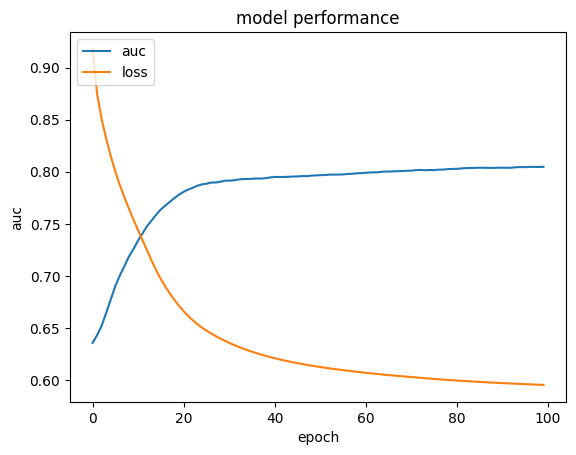

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training.history['auc'])
plt.plot(training.history['loss'])
plt.title('model performance')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['auc', 'loss'], loc='upper left')
plt.show()

###My results

<img src='' height=300>

In [ ]:
max(training.history['auc']), min(training.history['loss'])  #(0.8047691583633423, 0.5954418182373047)

(0.8047691583633423, 0.5954418182373047)

In [ ]:
training.history['auc'][-20:]

[0.8028106093406677,
 0.8032148480415344,
 0.8035212755203247,
 0.8035858869552612,
 0.8037409782409668,
 0.803877592086792,
 0.8038018941879272,
 0.8037317395210266,
 0.8037077784538269,
 0.8039089441299438,
 0.8038609623908997,
 0.8037742376327515,
 0.8038665056228638,
 0.8043925762176514,
 0.80446457862854,
 0.80442214012146,
 0.8046971559524536,
 0.80467689037323,
 0.8045679330825806,
 0.8047691583633423]

###My results

<pre>
[0.8028106093406677,
 0.8032148480415344,
 0.8035212755203247,
 0.8035858869552612,
 0.8037409782409668,
 0.803877592086792,
 0.8038018941879272,
 0.8037317395210266,
 0.8037077784538269,
 0.8039089441299438,
 0.8038609623908997,
 0.8037742376327515,
 0.8038665056228638,
 0.8043925762176514,
 0.80446457862854,
 0.80442214012146,
 0.8046971559524536,
 0.80467689037323,
 0.8045679330825806,
 0.8047691583633423]
 </pre>

In [ ]:
training.history['loss'][-20:]

[0.5996474027633667,
 0.5993703603744507,
 0.5991257429122925,
 0.5988380312919617,
 0.5985915064811707,
 0.5983326435089111,
 0.5981044769287109,
 0.597854733467102,
 0.5976247191429138,
 0.5973939895629883,
 0.597191333770752,
 0.5969778299331665,
 0.5967769026756287,
 0.5965700149536133,
 0.5963735580444336,
 0.5961760878562927,
 0.5959934592247009,
 0.59579998254776,
 0.5956194996833801,
 0.5954418182373047]

###How to inperpret all this

Early stopping did not kick in. That might imply that we should add more epochs. But I am going to stop at this point given very marginal gains.

That said, there is another callback that often goes with early stopping, one that also watches validation results: `ReduceLROnPlateau`. If it sees lack of improvement, it will try to adjust training parameters on the fly to improve things. Kind of cool: adapt as you go. I am not sure we will have time to get to it.

##Evaluate on test set

There is no `score` method. And `predict_proba` has been replaced with just `predict`. And `predict` just gives you probabilities of 1 (positive case).

And remember our `ann_model` is not from the last epoch, but the one with the smallest loss as found by early stopping.

In [ ]:
ypos = ann_model.predict(x_test)[:,0]  #replaces predict_proba but only pos case (each value wrapped in array so need of [:,0])
ypos[:5]  #[0.60781306, 0.7760794 , 0.8345735 , 0.24593781, 0.28484714]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([0.60781306, 0.7760794 , 0.8345735 , 0.24593781, 0.28484714],
      dtype=float32)

In [ ]:
result_df, fancy_df = threshold_results(np.round(np.arange(0.0,1.01,.05), 2), y_test, ypos)
fancy_df

,threshold,precision,recall,f1,accuracy,auc
0,0.00,0.43,1.00,0.60,0.43,0.78
1,0.05,0.43,1.00,0.60,0.43,0.78
2,0.10,0.43,1.00,0.60,0.43,0.78
3,0.15,0.44,0.99,0.61,0.44,0.78
4,0.20,0.46,0.97,0.62,0.49,0.78
5,0.25,0.50,0.93,0.65,0.57,0.78
6,0.30,0.56,0.82,0.66,0.64,0.78
7,0.35,0.62,0.75,0.68,0.69,0.78
8,0.40,0.66,0.65,0.65,0.70,0.78
9,0.45,0.72,0.59,0.65,0.72,0.78


In [ ]:
result_df

,threshold,precision,recall,f1,accuracy,auc
0,0.00,0.43,1.00,0.60,0.43,0.78
1,0.05,0.43,1.00,0.60,0.43,0.78
2,0.10,0.43,1.00,0.60,0.43,0.78
3,0.15,0.44,0.99,0.61,0.44,0.78
4,0.20,0.46,0.97,0.62,0.49,0.78
5,0.25,0.50,0.93,0.65,0.57,0.78
6,0.30,0.56,0.82,0.66,0.64,0.78
7,0.35,0.62,0.75,0.68,0.69,0.78
8,0.40,0.66,0.65,0.65,0.70,0.78
9,0.45,0.72,0.59,0.65,0.72,0.78


###My results

Not great compared to last chapter. But really need to tune to get better picture. We will do that in next chapter.

<img src='' height=400>

##Saving and loading for future reference

Code below is just to show you you can  save and load your ANN models. Next chapter will do it for real.

In [ ]:
ann_model.save('my_model.keras')

model2 = tf.keras.models.load_model('my_model.keras') #load back in

In [ ]:
ypos = model2.predict(x_test)[:,0]
ypos[:5]  #[0.60781306, 0.7760794 , 0.8345735 , 0.24593781, 0.28484714] - matches original

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


array([0.60781306, 0.7760794 , 0.8345735 , 0.24593781, 0.28484714],
      dtype=float32)

#VIII. Dropout

Even though I commented it out, it is an interesting idea. In an attempt to avoid a network overfitting, and making it more resilient, you can add a layer that  randomly "turns off" some percentage of nodes in the upstream layer (!) Check this out:

<img src='https://miro.medium.com/max/518/0*EY8R7nS10y5kQzOx'>

The consequence is that by turning off the output of a node (shown as red), we in essence come up with a new network missing that node. This is taken care of behind the scenes. The result is we train N separate networks. Kind of wild.

Notice I can also turn off input nodes. So eliminating a feature in a row. Maybe this is the most obvious case of resiliency. The network cannot rely solely on one or two features of a row; they may be dropped out. It has to adapt to use all the features. I decided not to do this given our already small set of features: 6.

When training is over, actual testing removes the dropout layers so you get the full model back.

This has proven quite powerful. It forces the network to be resilient.

###Relation to neuroscience

I've seen at least one paper that claims to find the use of dropout in an ANN as similar to results from brain study: https://www.frontiersin.org/articles/10.3389/fnagi.2020.00273/full.

###Problems in Tensorflow

It introduces uncontrollable nondeterminism. Hence, you cannot get replicable results on repeated runs. I see no real barrier to the Tensorflow developers fixing this. They just have not yet.

#Challenges

I'm going to give you a set of challenges to build a feedforward network then try it out on a couple of examples.

Here is test network to play with.

<img src='https://codingvision.net/imgs/posts/c-backpropagation-tutorial-xor/1.png'>

##Just as an aside

We can train this model to learn the XOR function.

<img src='https://www.dropbox.com/s/oeud4lstd84l88d/Screenshot%202020-02-21%2013.27.25.png?raw=1' height=300>

You can see that no linear solution is going to work. I think it is kind of cool that a simple net like this can learn XOR.

###Let's add some weights

Note that I am using a uniform random distribution to set weights. In the next chapter, we will see there are more sophisticated algorithms for initializing the weights.

In [ ]:
np.random.seed(seed=1234)  #so we will get same random numbers
hidden1 = list(np.random.uniform(-1,1,2))  #create list of 2 random items with uniform distribution between -1 and 1
hidden2 = list(np.random.uniform(-1,1,2))  #ditto
output = list(np.random.uniform(-1,1,2))   #ditto

In [ ]:
hidden1  #W11 and W21  [-0.6169610992422154, 0.24421754207966373]

[np.float64(-0.6169610992422154), np.float64(0.24421754207966373)]

In [ ]:
hidden2  #W12 and W22  [-0.12454452198577104, 0.5707171674275384]

[np.float64(-0.12454452198577104), np.float64(0.5707171674275384)]

In [ ]:
output  #w13 and w23  [0.559951616237607, -0.45481478943471676]

[np.float64(0.559951616237607), np.float64(-0.45481478943471676)]

In [ ]:
test_network = [
    # hidden layer
    [hidden1, # weights for hidden node 1 = [w11,w21]
     hidden2], # weights for hidden node 2 = [w12,w22]
   # output layer
   [output]]  # w13 and w23 - notice not output but [output], i.e., a list


###Why is `output` a list?

The output layer only has one node. Why put it in a list, i.e., `[output]`?

Because the output layer can have one **or more** nodes. If you are classifying 3 things, it might have 3 nodes.

In [ ]:
len(test_network)  #2 and not 3. Hidden layers are in their own nested list

2

In [ ]:
test_network

[[[np.float64(-0.6169610992422154), np.float64(0.24421754207966373)],
  [np.float64(-0.12454452198577104), np.float64(0.5707171674275384)]],
 [[np.float64(0.559951616237607), np.float64(-0.45481478943471676)]]]

Here it is in relation to our diagram.

<img src='https://www.dropbox.com/s/a8s43c314op5qg8/Screenshot%202020-05-13%2015.11.06.png?raw=1' height=500>

##Did you notice anything interesting?

The entire network is now represented as a list of lists. No nodes. No lines. Just lists of weights.

#Challenge 1

Define `sigmoid` and `relu` functions.

In [ ]:
import math
def sigmoid(z):
  return 1 / (1 + math.exp(-z))

In [ ]:
assert sigmoid(-0.155) == 0.46132739479349205

In [ ]:
def relu(z):
  return max(0,z)

In [ ]:
assert relu(-.002) == 0.0

In [ ]:
assert relu(.002)  == 0.002

#Challenge 2

Define a function that implements a neuron.

Note that I am requiring all parameters to be keyword by adding `*` in front.

In [ ]:
def neuron_output(*, inputs, weights, af=relu):
  assert isinstance(weights, list), f'weights should be a list but is instead a {type(weights)}'
  assert isinstance(inputs, list), f'inputs should be a list but is instead a {type(inputs)}'
  assert len(weights) == len(inputs), f'weights and inputs should be the same length, but are {len(weights)} and {len(inputs)}'
  assert callable(af), f'af must be a function but is instead {type(af)}'
  return af(np.dot(inputs, weights))


##Test

In [ ]:
assert neuron_output(inputs=[1,1], weights=hidden1)  == 0.0

In [ ]:
assert neuron_output(inputs=[1,3], weights=hidden1)  == 0.11569152699677576

In [ ]:
assert neuron_output(inputs=[1,1], weights=hidden2)  == 0.4461726454417674


#Challenge 3

We already have the `neuron_output` function. So use it to get the values for all the nodes in a layer and put them in a list. That list is the layer output, a value for each node in the layer.

In [ ]:
 def layer_output(*, inputs, layer, af=relu):
  assert isinstance(layer, list), f'layer must be a list but is a {type(layer)}'
  assert all([isinstance(item, list) for item in layer]), f'layer must be a list of lists'
  assert isinstance(inputs, list), f'inputs must be a list but is a {type(inputs)}'
  assert callable(af)

  #get the value for each node in layer and put in new list - use list comprehension
  return [neuron_output(inputs=inputs, weights=node, af=af) for node in layer]

##Test

In [ ]:
layer1 = test_network[0]  #first hidden layer
layer1

[[np.float64(-0.6169610992422154), np.float64(0.24421754207966373)],
 [np.float64(-0.12454452198577104), np.float64(0.5707171674275384)]]

<pre>
[[-0.6169610992422154, 0.24421754207966373],
 [-0.12454452198577104, 0.5707171674275384]]
 </pre>

So layer has list of 2 weights for hidden1 and list of 2 weights for hidden2. They are the 2 nodes in the layer.

Now produce the output for the first layer.

In [ ]:
hidden1_output = layer_output(inputs=[1,3], layer=layer1)
hidden1_output  #[0.11569152699677576, 1.5876069802968442]

[np.float64(0.11569152699677576), np.float64(1.5876069802968442)]

There are 2 nodes in the hidden layer so we get an output from each. Here is a picture.

<img src='https://www.dropbox.com/s/mbnbw3s3sdp4tnj/Screen%20Shot%202021-05-05%20at%208.20.00%20AM.png?raw=1' height=200>

Now here is the cool part. We take the output and make it the input to the 2nd layer, i.e., the output layer.

<img src='https://www.dropbox.com/s/6tvf33ezo2g7k6i/Screen%20Shot%202021-05-05%20at%208.23.11%20AM.png?raw=1' height=200>

In [ ]:
input_vector = hidden1_output  #tricky - taking output and making it new input!
layer2 = test_network[1]  #next layer, i.e., output layer
layer2  #[[0.559951616237607, -0.45481478943471676]]

[[np.float64(0.559951616237607), np.float64(-0.45481478943471676)]]

Now ready to produce next output, which is the actual output of the entire network!

In [ ]:
output = layer_output(inputs=input_vector, layer=layer2, af=sigmoid)
output  #[0.34134965486093866]

[0.34134965486093866]

#Challenge 4

Create the full feedforward function. Should only need calls on `layer_output` at this point.

I needed one non-nested loop.

In [ ]:
def feed_forward(*, neural_network, input_vector):
  # process hidden layer(s) one layer at a time
  # slide left to right

  for layer in neural_network[:-1]:  #all but last layer
    input_vector = layer_output(inputs=input_vector, layer=layer)

  #output layer is last layer and uses sigmoid
  output_layer = neural_network[-1]
  return layer_output(inputs=input_vector, layer=output_layer, af=sigmoid)


Try it out.

In [ ]:
raw_prediction = feed_forward(neural_network=test_network, input_vector=[1,3])
raw_prediction  #[0.34134965486093866] - same as in challenge 3


[0.34134965486093866]

In [ ]:
raw_prediction = feed_forward(neural_network=test_network, input_vector=[0,0])
raw_prediction  #[0.5]


[0.5]

#Challenge 5

Try it out on a new network.

In [ ]:
np.random.seed(seed=1234)
#hidden layer 1
hidden1_1 = list(np.random.uniform(-1,1,2))  #create list of 2 random items with uniform distribution between -1 and 1
hidden1_2 = list(np.random.uniform(-1,1,2))  #ditto
hidden1_3 = list(np.random.uniform(-1,1,2))  #ditto
#hidden layer 2
hidden2_1 = list(np.random.uniform(-1,1,3))  #create list of 3 random items with uniform distribution between -1 and 1
hidden2_2 = list(np.random.uniform(-1,1,3))  #ditto
#output
output = list(np.random.uniform(-1,1,2))   #back to 2 random items

In [ ]:
test_network2 = [
    # hidden layer 1 with 3 nodes
    [hidden1_1, hidden1_2, hidden1_3],
    # hidden layer 2 with 2 nodes
    [hidden2_1, hidden2_2],
   # output layer
   [output]]


In [ ]:
raw_prediction = feed_forward(neural_network=test_network2, input_vector=[1,3])
raw_prediction  #[0.5824218686667751]


[0.5824218686667751]

In [ ]:
raw_prediction = feed_forward(neural_network=test_network2, input_vector=[0,0])
raw_prediction  #[0.5]


[0.5]